# README

This code generates the optimization surface for set c1 and c2 values while varying the T21 and T22 values. It plots a surface plot and a heat map to show the minimization surface.

In [158]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys

# Initialize Parameters

In [159]:
noise_opt = False

In [160]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.3
c2 = 0.7 
T21 = 40
T22 = 60

true_params = np.array([c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

#Space around the T2 parameters
T21_grid = np.arange(T21-20, T21+20.01, 0.5)
T22_grid = np.arange(T22-20, T22+20.01, 0.5)

#SNR Value to Evaluate
SNR_value = 100

ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

# Functions

In [161]:
def S_biX_6p(TE, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

#Defining the monoExp function of interest
def S_moX_3p_np1(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T11))*np.exp(-TE/T2)

def S_moX_3p_np2(TE, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T12))*np.exp(-TE/T2)

def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            RSS_opt1 = calculate_RSS_TI(S_moX_3p_np2, [param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            RSS_opt2 = calculate_RSS_TI(S_moX_3p_np1, [param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])
            RSS_add = np.min([RSS_opt1, RSS_opt2])

        curve_RSS += RSS_add

    return curve_RSS

# Generating Matrix

In [162]:
#### Multiple Signals

TI_DATA_var = np.array([0,np.log(2)*T11-2, np.log(2)*T12+2])

X_array_real = ["BiX","MoX","MoX"]#, "MoX"] #"BiX", 
X_array_default = ["BiX" for iter in X_array_real]

signal_array = np.zeros([len(TI_DATA_var), len(TE_DATA)])

for iTI in range(len(TI_DATA_var)):
    signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA_var[iTI])

if noise_opt:
    signal_array = add_noise(signal_array, SNR_value)

surface_array_BIC = np.zeros([len(T22_grid), len(T21_grid)])
surface_array_cvn = np.zeros([len(T22_grid), len(T21_grid)])

for iT21 in range(len(T21_grid)):
    for iT22 in range(len(T22_grid)):
        temp_param = [c1, c2, T21_grid[iT21], T22_grid[iT22]]
        temp_RSS = list_objective_func(temp_param, signal_array, TI_DATA_var, X_array_real)
        surface_array_BIC[iT22, iT21] = temp_RSS
        temp_RSS = list_objective_func(temp_param, signal_array, TI_DATA_var, X_array_default)
        surface_array_cvn[iT22, iT21] = temp_RSS

trueP_RSS_BIC = list_objective_func(true_params, signal_array, TI_DATA_var, X_array_real)
trueP_RSS_cvn = list_objective_func(true_params, signal_array, TI_DATA_var, X_array_default)

In [163]:
true_signal = signal_array[0,:] #only a single signal - noise is already added if necessary

surface_array = np.zeros([len(T22_grid), len(T21_grid)])

for iT21 in range(len(T21_grid)):
    for iT22 in range(len(T22_grid)):
        temp_param = [c1, c2, T21_grid[iT21], T22_grid[iT22]]
        temp_RSS = calculate_RSS_TI(S_biX_6p, temp_param, TI_DATA_var[0], true_signal)
        surface_array[iT22, iT21] = temp_RSS

trueP_RSS = calculate_RSS_TI(S_biX_6p, true_params, TI_DATA_var[0], true_signal)

Text(0.5, 0.98, "Curves\n['T11', 'T12', 'c1', 'c2', 'T21', 'T22'] = 600,1200,[ 0.3  0.7 40.  60. ]\nnoiseless")

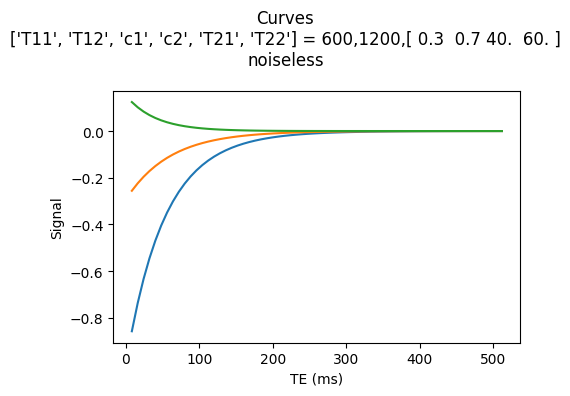

In [164]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
for iTI in range(len(TI_DATA_var)):
    plt.plot(TE_DATA, signal_array[iTI,:])
plt.xlabel('TE (ms)')
plt.ylabel('Signal')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"Curves\n{ParamTitle_6p} = {T11},{T12},{true_params}\n" + noise_info)

C:\Users\griff\AppData\Local\Temp\ipykernel_1296\369538727.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


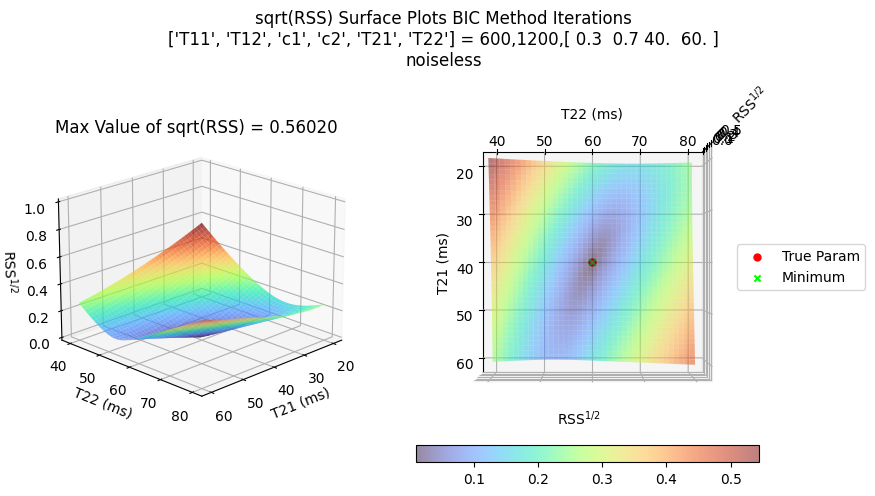

In [165]:
mT21, mT22 = np.meshgrid(T21_grid, T22_grid)

fig = plt.figure(figsize=(9,5), tight_layout=True)

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.plot_surface(mT21, mT22, surface_array_BIC**(1/2), alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel('T21 (ms)')
ax1.set_ylabel('T22 (ms)')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.set_zlim([0,1])
ax1.set_title(f'Max Value of sqrt(RSS) = {np.max(surface_array_BIC**(1/2)):.5f}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

flat = ax1.plot_surface(mT21, mT22, surface_array_BIC**(1/2), alpha = 0.5, cmap = 'turbo')
ax1.set_xlabel('T21 (ms)')
ax1.set_ylabel('T22 (ms)')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.scatter(T21, T22, trueP_RSS_BIC, color = (1,0,0), marker = 'o', s = 25, label = 'True Param')
rootRSS = surface_array_BIC**(1/2)
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax1.scatter(T21_grid[min_indices[1]], T22_grid[min_indices[0]], np.min(surface_array_BIC**(1/2)), color = (0,1,0), marker = 'x', s = 20, label = 'Minimum')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# ax1.set_title('RSS Surface')
ax1.view_init(90,0)
fig.colorbar(flat, ax=ax1, fraction=0.046, pad = 0.0001, location = 'bottom')
fig.text(0.65, 0.15, r'RSS$^{1/2}$', ha='center')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"sqrt(RSS) Surface Plots BIC Method Iterations\n{ParamTitle_6p} = {T11},{T12},{true_params}\n" + noise_info)

plt.show()

C:\Users\griff\AppData\Local\Temp\ipykernel_1296\1681464363.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


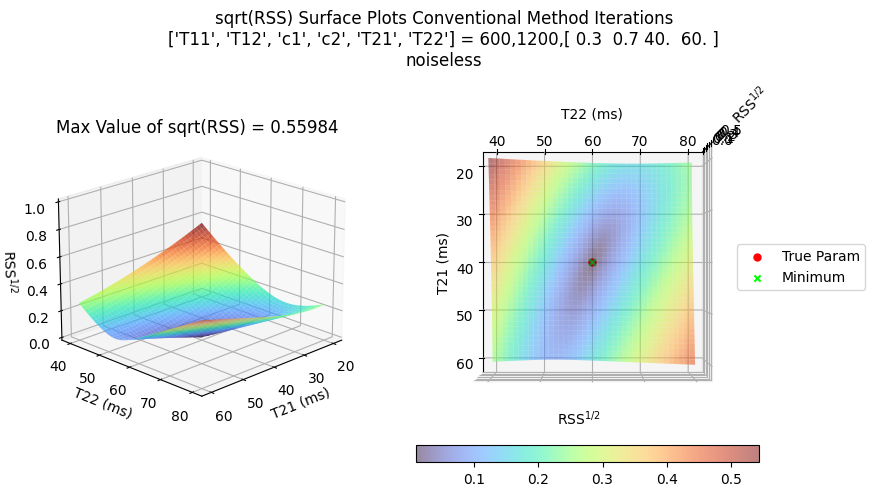

In [166]:
mT21, mT22 = np.meshgrid(T21_grid, T22_grid)

fig = plt.figure(figsize=(9,5), tight_layout=True)

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

ax1.plot_surface(mT21, mT22, surface_array_cvn**(1/2), alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel('T21 (ms)')
ax1.set_ylabel('T22 (ms)')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.set_zlim([0,1])
ax1.set_title(f'Max Value of sqrt(RSS) = {np.max(surface_array_cvn**(1/2)):.5f}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

flat = ax1.plot_surface(mT21, mT22, surface_array_cvn**(1/2), alpha = 0.5, cmap = 'turbo')
ax1.set_xlabel('T21 (ms)')
ax1.set_ylabel('T22 (ms)')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.scatter(T21, T22, trueP_RSS_cvn, color = (1,0,0), marker = 'o', s = 25, label = 'True Param')
rootRSS = surface_array_cvn**(1/2)
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax1.scatter(T21_grid[min_indices[1]], T22_grid[min_indices[0]], np.min(surface_array_cvn**(1/2)), color = (0,1,0), marker = 'x', s = 20, label = 'Minimum')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# ax1.set_title('RSS Surface')
ax1.view_init(90,0)
fig.colorbar(flat, ax=ax1, fraction=0.046, pad = 0.0001, location = 'bottom')
fig.text(0.65, 0.15, r'RSS$^{1/2}$', ha='center')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"sqrt(RSS) Surface Plots Conventional Method Iterations\n{ParamTitle_6p} = {T11},{T12},{true_params}\n" + noise_info)

plt.show()

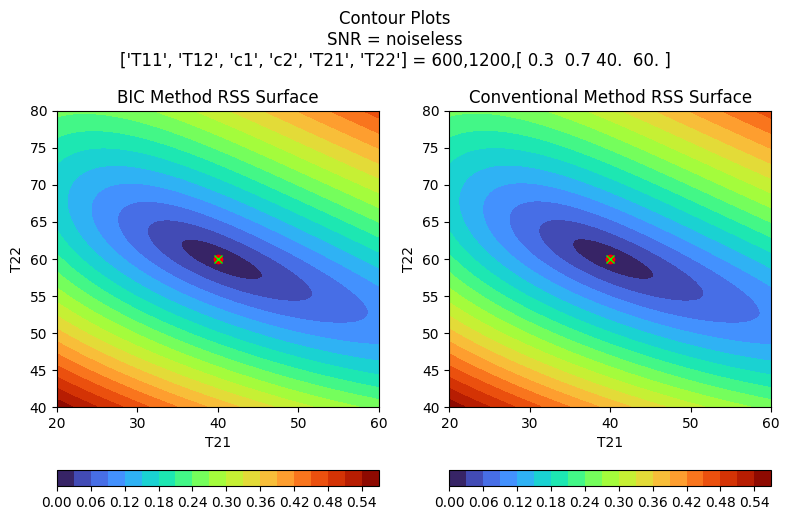

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Contour Plots\nSNR = {noise_info}\n{ParamTitle_6p} = {T11},{T12},{true_params}")


cp = ax[0].contourf(mT21, mT22, surface_array_BIC**(1/2), 20, cmap = 'turbo')
ax[0].plot(T21, T22, color = (1,0,0), marker = 'o', label = 'True Param')
rootRSS = surface_array_BIC**(1/2)
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax[0].plot(T21_grid[min_indices[1]], T22_grid[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax[0].set_xlabel('T21')
ax[0].set_ylabel('T22')
ax[0].set_title('BIC Method RSS Surface')
fig.colorbar(cp, ax = ax[0], location = 'bottom')

cp = ax[1].contourf(mT21, mT22, surface_array_cvn**(1/2), 20, cmap = 'turbo')
ax[1].plot(T21, T22, color = (1,0,0), marker = 'o', label = 'True Param')
rootRSS = surface_array_cvn**(1/2)
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax[1].plot(T21_grid[min_indices[1]], T22_grid[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax[1].set_xlabel('T21')
ax[1].set_ylabel('T22')
ax[1].set_title('Conventional Method RSS Surface')
fig.colorbar(cp, ax = ax[1], location = 'bottom')

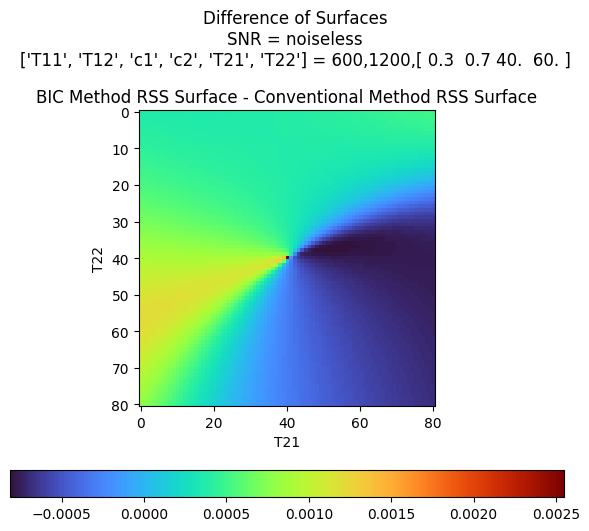

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(6,5.5), tight_layout=True)
fig.suptitle(f"Difference of Surfaces\nSNR = {noise_info}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

diff_vals = surface_array_BIC**(1/2) - surface_array_cvn**(1/2)

cp = ax.imshow(diff_vals, cmap = 'turbo')
ax.set_xlabel('T21')
ax.set_ylabel('T22')
# ax.set_xticks(np.arange(len(T21_grid)))
# ax.set_yticks(np.arange(len(T22_grid)))
# ax.set_xticklabels(T21_grid)
# ax.set_yticklabels(T22_grid)
# original_labels = [np.round(label,2) for label in delta_array]
# labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
# new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax.set_title('BIC Method RSS Surface - Conventional Method RSS Surface')
fig.colorbar(cp, ax = ax, location = 'bottom')

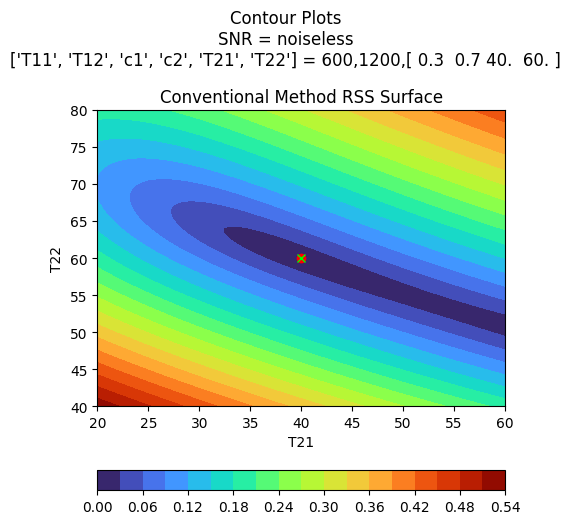

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(5,5.5), tight_layout=True)
fig.suptitle(f"Contour Plots\nSNR = {noise_info}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

cp = ax.contourf(mT21, mT22, surface_array**(1/2), 20, cmap = 'turbo')
ax.plot(T21, T22, color = (1,0,0), marker = 'o', label = 'True Param')
rootRSS = surface_array**(1/2)
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax.plot(T21_grid[min_indices[1]], T22_grid[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax.set_xlabel('T21')
ax.set_ylabel('T22')
ax.set_title('Conventional Method RSS Surface')
fig.colorbar(cp, ax = ax, location = 'bottom')

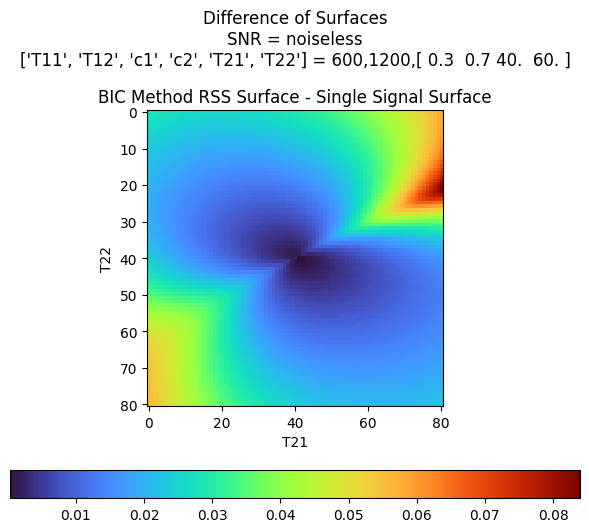

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(6,5.5), tight_layout=True)
fig.suptitle(f"Difference of Surfaces\nSNR = {noise_info}\n{ParamTitle_6p} = {T11},{T12},{true_params}")

diff_vals = surface_array_BIC**(1/2) - surface_array**(1/2)

cp = ax.imshow(diff_vals, cmap = 'turbo')
ax.set_xlabel('T21')
ax.set_ylabel('T22')
# ax.set_xticks(np.arange(len(T21_grid)))
# ax.set_yticks(np.arange(len(T22_grid)))
# ax.set_xticklabels(T21_grid)
# ax.set_yticklabels(T22_grid)
# original_labels = [np.round(label,2) for label in delta_array]
# labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
# new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax.set_title('BIC Method RSS Surface - Single Signal Surface')
fig.colorbar(cp, ax = ax, location = 'bottom')